<a href="https://colab.research.google.com/github/Akechi1412/Vietnamese-Review-Classification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!rm -rf Vietnamese-Review-Classification
!git clone https://github.com/Akechi1412/Vietnamese-Review-Classification
%cd Vietnamese-Review-Classification

Cloning into 'Vietnamese-Review-Classification'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 66 (delta 32), reused 42 (delta 12), pack-reused 0
Receiving objects: 100% (66/66), 589.12 KiB | 9.20 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/Vietnamese-Review-Classification/Vietnamese-Review-Classification


In [14]:
!sudo apt-get install python3.7
!pip install pyvi https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz --upgrade

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.7 is already the newest version (3.7.17-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
  Using cached https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz (233.3 MB)
  Preparing metadata (setup.py) ... done


In [15]:
# !git pull origin master

From https://github.com/Akechi1412/Vietnamese-Review-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


Preparing data...
Data size: 9000
Max number of words: 476
['đọc', 'cuốn', 'sách', 'tập', '1', 'mình', 'đã', 'nhận', 'ra', 'những', 'điều', 'thiếu sót', 'trong', 'quá trình', 'quản trị', 'doanh nghiệp', 'của', 'mình', 'chưa', 'có', 'tầm', 'nhìn', 'sứ mệnh', 'và', 'các', 'giá trị', 'cốt lõi', 'dẫn', 'đến', 'lúng túng', 'và', 'không thể', 'vận hành', 'doanh nghiệp', '1', 'cách', 'trơn tru', 'trong', 'sách', 'còn', 'có', 'nhiều', 'quà', 'tặng', 'đi', 'kèm', 'cực', 'giá trị', 'mình', 'đọc', 'mà', 'quên', 'cả', 'ăn', 'luôn', 'đúng', 'là', 'cuốn', 'sách', 'giá trị', 'trong', 'các', 'cuốn', 'sách', 'mình', 'đã', 'từng', 'đọc']
0


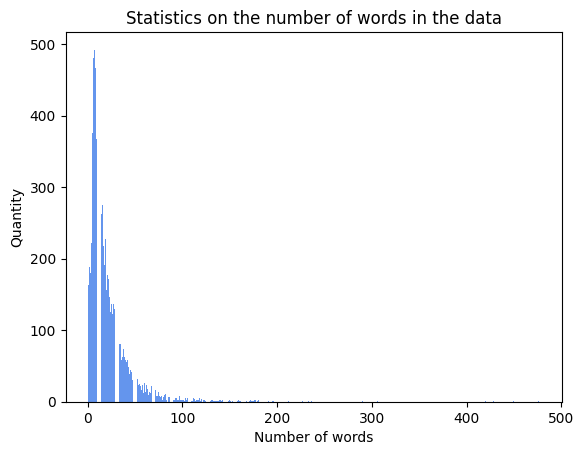

In [16]:
from utils.data_preparing import prepare_data
from utils.plotter import plot_reviews_data

x_data, y_data = prepare_data()

print(f'Data size: {len(x_data)}')
print(f'Max number of words: {len(max(x_data, key=len))}')
print(x_data[0])
print(y_data[0])

plot_reviews_data(x_data)

In [17]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=1/3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

6000 6000
1500 1500
1500 1500


In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to ensure uniform length
max_len = 200
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

print(f'({len(x_train_pad)}, {len(x_train_pad[0])})')
print(f'({len(x_val_pad)}, {len(x_val_pad[0])})')
print(f'({len(x_test_pad)}, {len(x_test_pad[0])})')

# Create one hot
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

(6000, 200)
(1500, 200)
(1500, 200)


In [19]:
import numpy as np

x_train_pad = np.array(x_train_pad)
x_val_pad = np.array(x_val_pad)
x_test_pad = np.array(x_test_pad)

y_train_one_hot = np.array(y_train_one_hot)
y_val_one_hot = np.array(y_val_one_hot)
y_test_one_hot = np.array(y_test_one_hot)

In [33]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras import regularizers

# Build RNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len))
model.add(LSTM(units=64))
model.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(rate=0.5))
model.add(Dense(units=8, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(rate=0.5))
model.add(Dense(units=3, activation='softmax', kernel_regularizer=regularizers.L2(0.01)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train_pad, y_train_one_hot, batch_size=50, epochs=10, validation_data=(x_val_pad, y_val_one_hot))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 100)          764800    
                                                                 
 lstm_7 (LSTM)               (None, 64)                42240     
                                                                 
 dense_27 (Dense)            (None, 16)                1040      
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 8)                 136       
                                                                 
 dropout_21 (Dropout)        (None, 8)                 0         
                                                                 
 dense_29 (Dense)            (None, 3)                

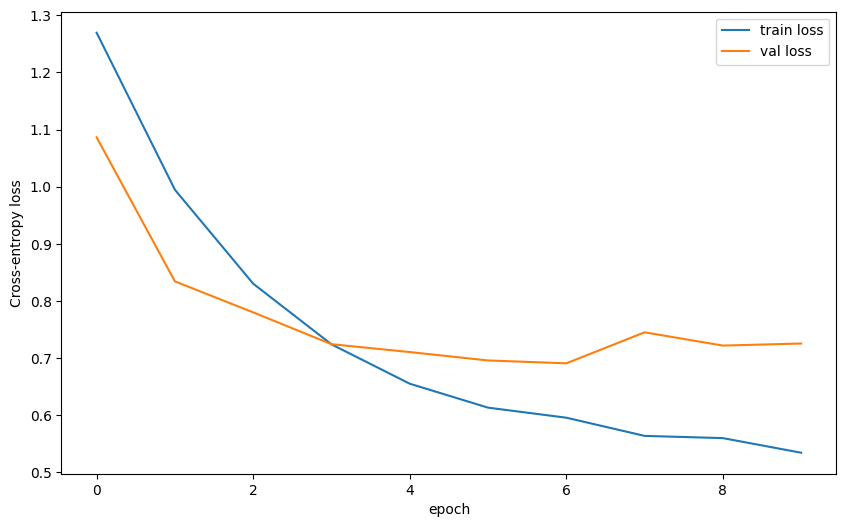

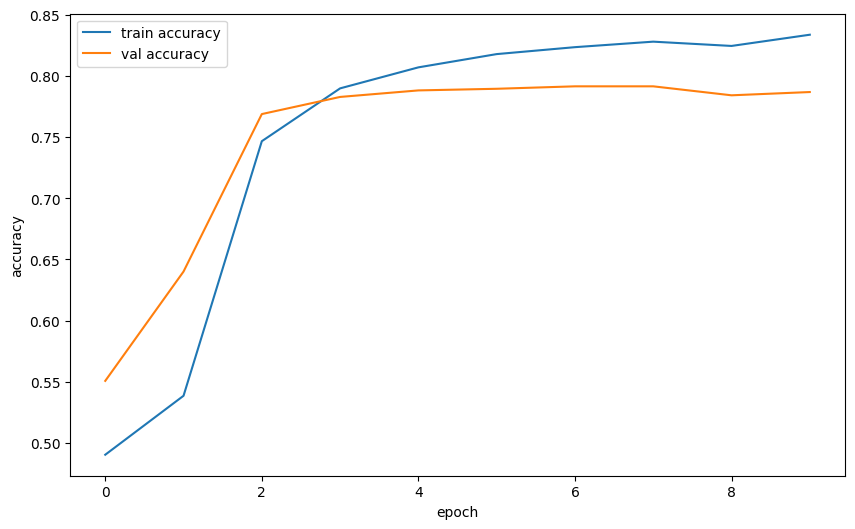

In [34]:
from utils.plotter import plot_history_model

plot_history_model(history)

In [36]:
from sklearn.metrics import confusion_matrix

score, acc = model.evaluate(x_test_pad, y_test_one_hot, batch_size=15, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

y_pred = model.predict(x_test_pad, batch_size=15)
y_test_single = np.argmax(y_test_one_hot, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_pred_single)
print("Confusion Matrix:")
print(conf_matrix)

100/100 - 5s - loss: 0.7278 - accuracy: 0.7827 - 5s/epoch - 47ms/step
Test score: 0.727829098701477
Test accuracy: 0.7826666831970215
100/100 [==============================] - 6s 61ms/step
Confusion Matrix:
[[723  78   0]
 [ 52 451   0]
 [ 53 143   0]]


In [38]:
model.save('./models/review_model.keras')